In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

- Load and prepare data

In [19]:
df = pd.read_csv('delhi_aqi_with_full_index.csv')

- Convert date to datetime

In [20]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [21]:
df

,date,AQI,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,446,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,2020-11-25 02:00:00,480,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,2020-11-25 03:00:00,486,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,2020-11-25 04:00:00,482,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,2020-11-25 05:00:00,479,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61
...,...,...,...,...,...,...,...,...,...,...
18771,2023-01-24 04:00:00,386,1762.39,4.64,37.01,33.26,30.52,231.15,289.84,6.27
18772,2023-01-24 05:00:00,381,1735.69,6.82,34.96,46.49,34.33,225.08,280.52,9.12
18773,2023-01-24 06:00:00,394,1922.61,8.16,40.10,56.51,43.39,242.49,296.07,12.54
18774,2023-01-24 07:00:00,335,1361.85,9.05,52.78,71.53,100.14,165.67,191.82,7.47


In [22]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print("\n" + "="*80 + "\n")

Missing values per column:
date     0
AQI      0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64




In [23]:
# Handle missing values (forward fill then backward fill)
df = df.fillna(method='ffill').fillna(method='bfill')

In [24]:
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print("\n" + "="*80 + "\n")

Dataset shape: (18776, 10)
Date range: 2020-11-25 01:00:00 to 2023-01-24 08:00:00




- TIME SERIES ANALYSIS

- ADF Test (Augmented Dickey-Fuller Test) for Stationarity

In [ ]:
def adf_test(series, name=''):
    result = adfuller(series.dropna())
    print(f'\nADF Test for {name}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"Result: Series is STATIONARY (p-value = {result[1]} <= 0.05)")
    else:
        print(f"Result: Series is NON-STATIONARY (p-value = {result[1]} > 0.05)")
    return result

In [26]:
# Test stationarity of AQI
adf_result = adf_test(df['AQI'], 'AQI')


ADF Test for AQI:
ADF Statistic: -11.913203
p-value: 0.000000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567
Result: Series is STATIONARY (p-value = 0.000000 <= 0.05)


In [27]:
# Test stationarity of pollutants
for col in ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']:
    adf_test(df[col], col)

print("\n" + "="*80 + "\n")


ADF Test for co:
ADF Statistic: -11.042789
p-value: 0.000000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567
Result: Series is STATIONARY (p-value = 0.000000 <= 0.05)

ADF Test for no:
ADF Statistic: -12.369044
p-value: 0.000000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567
Result: Series is STATIONARY (p-value = 0.000000 <= 0.05)

ADF Test for no2:
ADF Statistic: -10.663501
p-value: 0.000000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567
Result: Series is STATIONARY (p-value = 0.000000 <= 0.05)

ADF Test for o3:
ADF Statistic: -7.731329
p-value: 0.000000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567
Result: Series is STATIONARY (p-value = 0.000000 <= 0.05)

ADF Test for so2:
ADF Statistic: -14.148845
p-value: 0.000000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567
Result: Series is STATIONARY (p-value = 0.000000 <= 0.05)

ADF Test for pm2_5:
ADF Statistic: -9.782452
p-value: 0.000000
Critical Values:
   1%: -3.431
   5

- VISUALIZATION

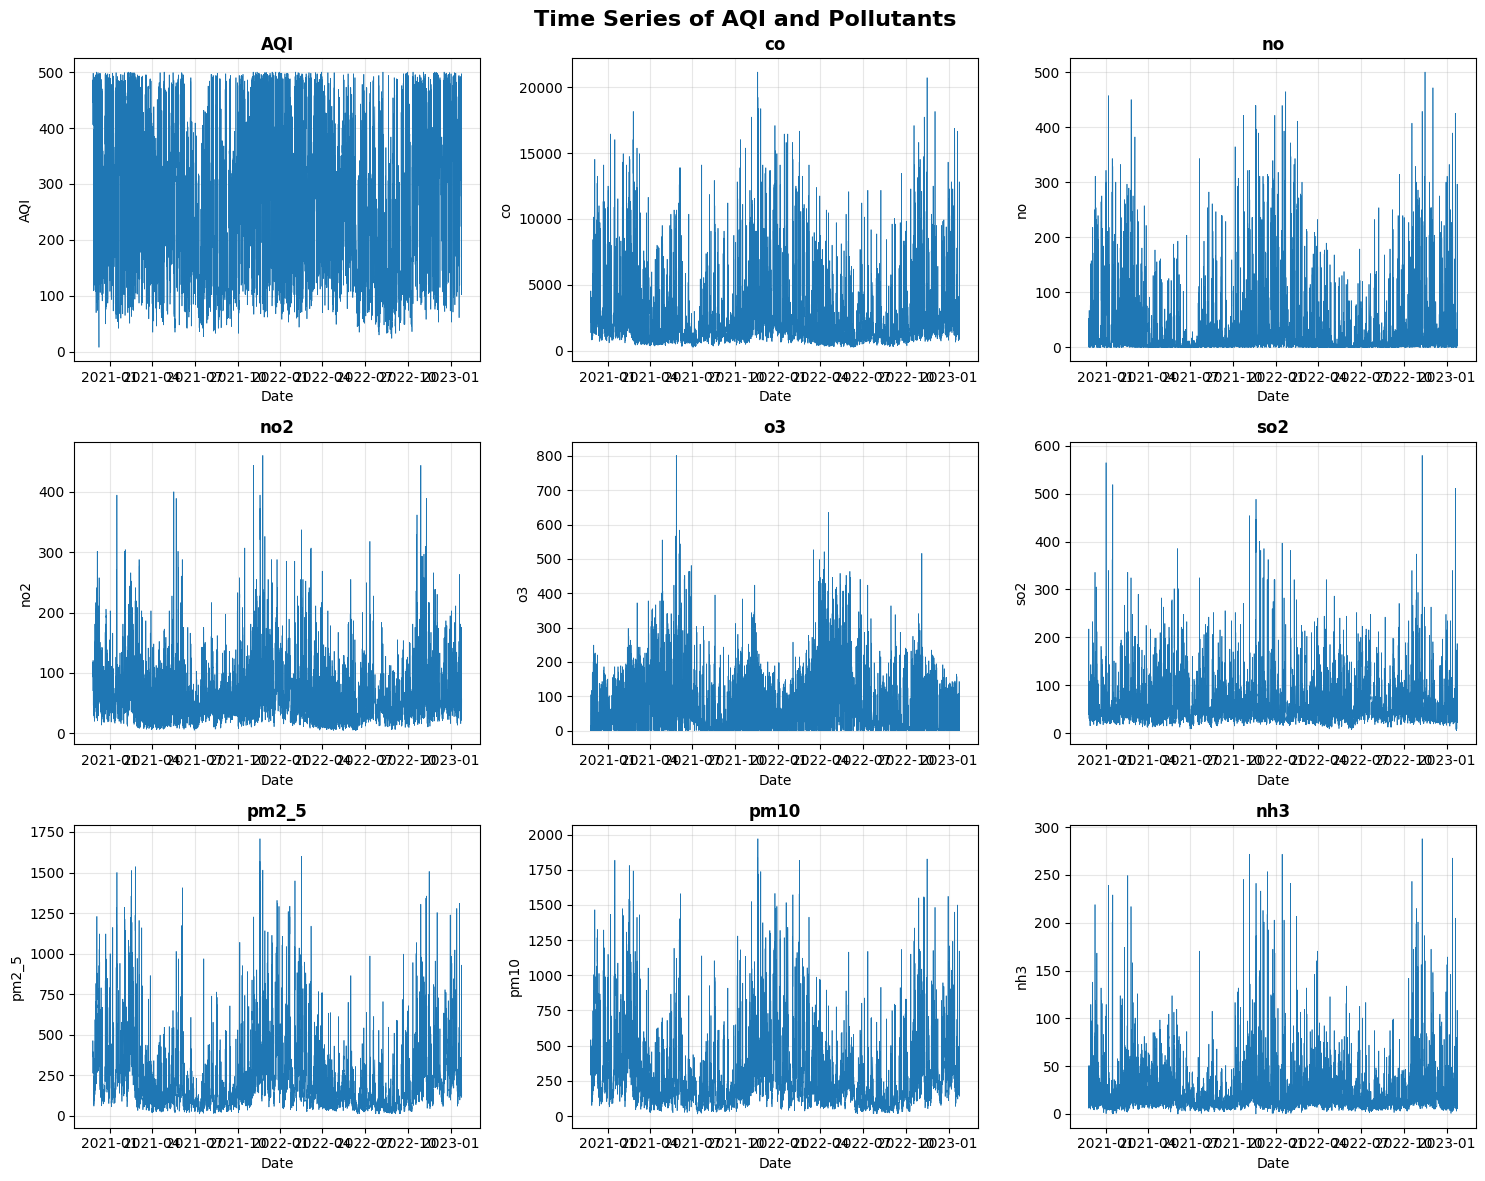

In [28]:
# Plot time series
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Time Series of AQI and Pollutants', fontsize=16, fontweight='bold')
columns = ['AQI', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
for idx, col in enumerate(columns):
    ax = axes[idx // 3, idx % 3]
    ax.plot(df['date'], df[col], linewidth=0.5)
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_plot.png', dpi=300, bbox_inches='tight')
plt.show()